# Aereal Drone Image Segmentation through U-net architecture

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import imageio.v2 as io
from sklearn.model_selection import train_test_split
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchsummary
from torchsummary import summary
import time

device= "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dataset_path = r'E:\Datasets\drone_seg_1'
class_csv_path = os.path.join(dataset_path, r'colormaps.xlsx')
original_images_path = os.path.join(dataset_path, r'semantic_drone_dataset\semantic_drone_dataset\original_images')
rgb_masks_path = os.path.join(dataset_path, r'classes_dataset\classes_dataset\label_images_semantic')
semantic_masks_path = os.path.join(dataset_path, r'semantic_drone_dataset\semantic_drone_dataset\label_images_semantic')

#Get the image and mask fullpaths
original_images = os.listdir(original_images_path)
original_images_fullpath = [os.path.join(original_images_path, image_path) for image_path in original_images]
rgb_masks = os.listdir(rgb_masks_path)
rgb_masks_fullpath = [os.path.join(rgb_masks_path, mask_path) for mask_path in rgb_masks]
semantic_masks = os.listdir(semantic_masks_path)
semantic_masks_fullpath = [os.path.join(semantic_masks_path, mask_path) for mask_path in semantic_masks]

## EDA

### Labels

In [3]:
labels = pd.read_excel(class_csv_path, engine='openpyxl')
labels = labels.iloc[:, :4]
labels

,Classes,R,G,B
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [4]:
labels_dict = {name:tuple(labels.iloc[index,1:]) for index, name in enumerate(labels.Classes)}
labels_dict

{'unlabeled': (0, 0, 0),
 'paved-area': (128, 64, 128),
 'dirt': (130, 76, 0),
 'grass': (0, 102, 0),
 'gravel': (112, 103, 87),
 'water': (28, 42, 168),
 'rocks': (48, 41, 30),
 'pool': (0, 50, 89),
 'vegetation': (107, 142, 35),
 'roof': (70, 70, 70),
 'wall': (102, 102, 156),
 'window': (254, 228, 12),
 'door': (254, 148, 12),
 'fence': (190, 153, 153),
 'fence-pole': (153, 153, 153),
 'person': (255, 22, 96),
 'dog': (102, 51, 0),
 'car': (9, 143, 150),
 'bicycle': (119, 11, 32),
 'tree': (51, 51, 0),
 'bald-tree': (190, 250, 190),
 'ar-marker': (112, 150, 146),
 'obstacle': (2, 135, 115),
 'conflicting': (255, 0, 0)}

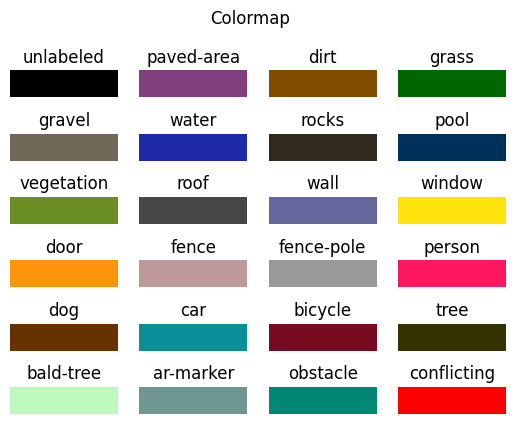

In [5]:
def print_colors_map(labels):
    for i, (name, color) in enumerate(labels.items()):
        plt.subplot(6,4,i+1)
        color_image = np.array([[color,color,color,color]])
        plt.title(name)
        plt.imshow(color_image)
        plt.axis('off')
        plt.suptitle('Colormap')

print_colors_map(labels_dict)

### Images

In [6]:
print(f'Total images: {len(original_images_fullpath)} - Total masks: {len(rgb_masks_fullpath)}')
print(original_images_fullpath[:2])
print(rgb_masks_fullpath[:2])

Total images: 400 - Total masks: 400
['E:\\Datasets\\drone_seg_1\\semantic_drone_dataset\\semantic_drone_dataset\\original_images\\000.jpg', 'E:\\Datasets\\drone_seg_1\\semantic_drone_dataset\\semantic_drone_dataset\\original_images\\001.jpg']
['E:\\Datasets\\drone_seg_1\\classes_dataset\\classes_dataset\\label_images_semantic\\000.png', 'E:\\Datasets\\drone_seg_1\\classes_dataset\\classes_dataset\\label_images_semantic\\001.png']


RGB Image shape: (4000, 6000, 3), RGB Mask resized shape: (736, 960, 3), Semantic Mask shape: (4000, 6000)


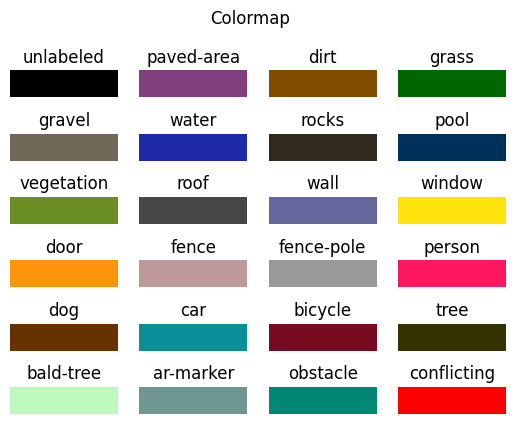

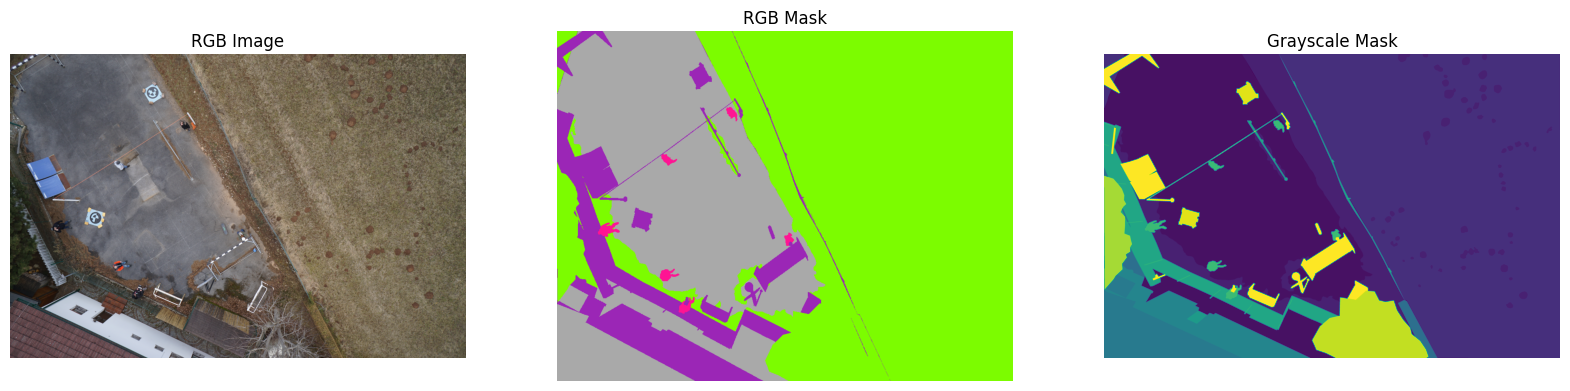

In [7]:
def plot_single_image_and_mask(img,mask):
    _, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(img)
    axs[0].set_title('RGB image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[0].axis('off')
    axs[1].axis('off')

def plot_three_images(img1, img2, img3, title_1, title_2, title_3):
    _,axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(img1)
    axs[0].set_title(title_1)
    axs[0].axis('off')
    axs[1].imshow(img2)
    axs[1].set_title(title_2)
    axs[1].axis('off')
    axs[2].imshow(img3)
    axs[2].set_title(title_3)
    axs[2].axis('off')

def plot_image_and_mask(imgs_path, masks_path, semantic_path, n=1):
    for _ in range(n):
        i = np.random.randint(0, len(imgs_path))
        img = io.imread(imgs_path[i])
        rgb_mask = io.imread(masks_path[i])
        semantic_mask = io.imread(semantic_path[i])
        plot_three_images(img, rgb_mask, semantic_mask, 'RGB Image', 'RGB Mask', 'Grayscale Mask')
        print(f'RGB Image shape: {img.shape}, RGB Mask resized shape: {rgb_mask.shape}, Semantic Mask shape: {semantic_mask.shape}')

def plot_tensor_image(image, tl, figsize=(10,10)):
    image = image[0].permute(1, 2, 0).numpy()
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(tl)
    plt.axis('off')
    plt.show()

print_colors_map(labels_dict)
plot_image_and_mask(original_images_fullpath, rgb_masks_fullpath, semantic_masks_fullpath)

## Dataset and Dataloader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, rotation_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.rotation_transform = rotation_transform
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        img_path = self.images_dir[idx]
        mask_path = self.masks_dir[idx]
        
        image = torchvision.io.read_image(img_path).float() / 255.0
        mask = torchvision.io.read_image(mask_path).long()

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

class RandomRotationTransform():
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img, mask):
        angle = np.random.uniform(-self.degrees, self.degrees)
        return transforms.functional.rotate(img, angle), transforms.functional.rotate(mask, angle)


# Image transformation
transform = transforms.Compose([
    transforms.Resize((224,336), antialias=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and Dataloader
dataset = CustomDataset(images_dir=original_images_fullpath,
                        masks_dir=semantic_masks_fullpath,
                        transform=transform,
                        rotation_transform=RandomRotationTransform(180))

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Iterar sobre el dataloader
images, masks = next(iter(dataloader))
print(f'Image shape: {images.shape}, Mask shape: {masks.shape}')

Image shape: torch.Size([16, 3, 224, 336]), Mask shape: torch.Size([16, 1, 224, 336])


In [9]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(dataset)
datasets_2 = train_val_dataset(datasets['val'], val_split=0.2)

train_dataset = datasets['train']
valid_dataset = datasets_2['train']
test_dataset = datasets_2['val']

print(f'Train lenght: {len(train_dataset)}, Valid lenght: {len(valid_dataset)}, Test lenght: {len(test_dataset)}')

Train lenght: 300, Valid lenght: 80, Test lenght: 20


## U-net architecture

In [10]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d((2, 2)),
            #nn.Dropout2d(0.25),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.start = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256) 
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.finish = OutConv(64, n_classes)

    def forward(self, x):
        # x = [bz,3,224,336]
        x1 = self.start(x)  # [bz,64,224,336]
        x2 = self.down1(x1) # [bz,128,112,168]
        x3 = self.down2(x2) # [bz,256,56,84]
        x4 = self.down3(x3) # [bz,512,28,42]
        x5 = self.down4(x4) # [bz,1024,14,21]

        y4 = self.up1(x5, x4) # [bz,512,28,42]
        y3 = self.up2(y4, x3) # [bz,256,56,84]
        y2 = self.up3(y3, x2) # [bz,128,112,168]
        y1 = self.up4(y2, x1) # [bz,1024,224,336]
        y =  self.finish(y1)  # [bz,23,224,336]

        return y

# n_channels=3 for RGB images
model = UNet(n_channels=3, n_classes=23)
model = model.to(device)

summary(model, (3, 224, 336))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 336]           1,792
       BatchNorm2d-2         [-1, 64, 224, 336]             128
              ReLU-3         [-1, 64, 224, 336]               0
            Conv2d-4         [-1, 64, 224, 336]          36,928
       BatchNorm2d-5         [-1, 64, 224, 336]             128
              ReLU-6         [-1, 64, 224, 336]               0
        DoubleConv-7         [-1, 64, 224, 336]               0
         MaxPool2d-8         [-1, 64, 112, 168]               0
            Conv2d-9        [-1, 128, 112, 168]          73,856
      BatchNorm2d-10        [-1, 128, 112, 168]             256
             ReLU-11        [-1, 128, 112, 168]               0
           Conv2d-12        [-1, 128, 112, 168]         147,584
      BatchNorm2d-13        [-1, 128, 112, 168]             256
             ReLU-14        [-1, 128, 1

## Training process

In [11]:
n_epochs = 50
epoch_number = 0
best_vloss = 1e6
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

writer_path = r'.\models\Reporter.txt'
def parameters_writer(parameters_list, save_path):
    with open(save_path, 'a+') as f:
        for param in parameters_list:
            f.write(f'{param}, ')
        f.write('\n')

ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    targets = torch.squeeze(targets, dim=1) # [bz, 1, w, h] to [bz, w, h] for CE Loss
    ce_loss = ce(preds, targets)
    acc = (torch.argmax(preds,1) == targets).float().mean()
    return ce_loss, acc

criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

############################## TRAIN LOOP #############################################

def train_one_epoch(epoch_index):
    running_loss = 0
    running_acc = 0
 
    for j, data in enumerate(train_dataloader):

        imgs, masks = data
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        #Get network outputs
        outputs = model(imgs)

        # Compute the loss and its gradients
        loss, acc = criterion(outputs, masks)
        #print(loss)

        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_acc += acc.item()
        
    return running_loss / (j + 1), running_acc / (j + 1)


for epoch in range(n_epochs):
    inicio = time.time()
    train_parameters = []

    model.train()
    avg_loss, avg_acc = train_one_epoch(epoch)

    # We don't need gradients on to do reporting
    running_vloss = 0.0
    running_vacc = 0.0
    model.eval()

    with torch.no_grad():
        for k, vdata in enumerate(valid_dataloader):
            vimgs, vmasks = vdata
            vimgs, vmasks = vimgs.to(device), vmasks.to(device)
            
            voutputs = model(vimgs)               

            vloss, vacc = criterion(voutputs, vmasks)

            running_vloss += vloss.item()
            running_vacc += vacc.item()
            
        avg_vloss = running_vloss / (k + 1)
        avg_vacc = running_vacc / (k + 1)

    fin = time.time()
    print(f'Epoch {epoch_number + 1} - Train_loss: {np.round(avg_loss,4)} - Valid_loss: {np.round(avg_vloss,4)} - Train_acc: {np.round(avg_acc,4)} \
            - Valid_acc: {np.round(avg_vacc,4)} - Tiempo: {(fin-inicio)/60.0} minutos - Estimado: {((n_epochs-epoch_number-1)*(fin-inicio))/60.0} minutos')
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = rf'.\models\best_Unet_seg.pth'
        torch.save(model.state_dict(), model_path)

    train_parameters.append(f'Epoch {epoch_number + 1} - Train_loss: {avg_loss} - Valid_loss: {avg_vloss} - Train_acc: {avg_acc} - Valid_acc: {avg_vacc}')
    parameters_writer(train_parameters, writer_path)

    epoch_number += 1

model_path = rf'.\models\last_Unet_seg.pth'
torch.save(model.state_dict(), model_path)

## Test trained net

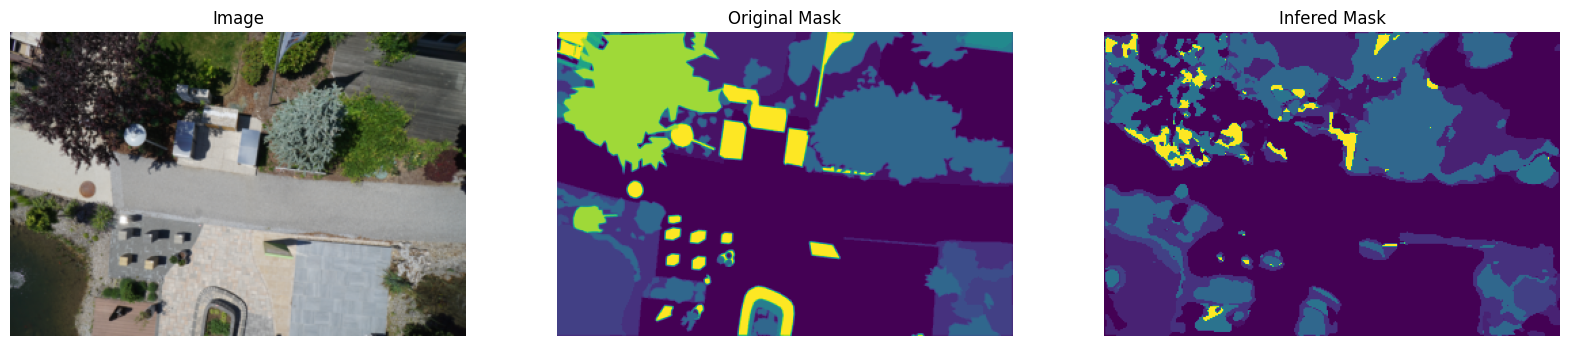

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
model.load_state_dict(torch.load(r'.\models\Unet_seg_ep6.pth'))

img, mask = next(iter(test_dataloader))
img = img.to(device)
out = model(img)

_,mask_out=torch.max(out,dim=1)
out = mask_out.unsqueeze(1)

def plot_three_tensor_images(img1, img2, img3, title_1, title_2, title_3):
    _,axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(img1[0].permute(1, 2, 0).numpy())
    axs[0].set_title(title_1)
    axs[0].axis('off')
    axs[1].imshow(img2[0].permute(1, 2, 0).numpy())
    axs[1].set_title(title_2)
    axs[1].axis('off')
    axs[2].imshow(img3[0].permute(1, 2, 0).numpy())
    axs[2].set_title(title_3)
    axs[2].axis('off')

plot_three_tensor_images(img.detach().cpu(), mask.detach().cpu(), out.detach().cpu(), 'Image', 'Original Mask', 'Infered Mask')